## Introduction

Wikipedia, one of the world's most visited websites, operates as a free, crowd-sourced encyclopedia. Its open-editing model enables broad contributions but also makes it susceptible to **linguistic bias**—subjective language or framing that subtly influences how readers perceive topics. While Wikipedia enforces factual accuracy, it lacks rigorous enforcement of **neutral tone**, especially in politically or socially charged topics.

This project addresses this challenge by developing an intelligent system to **detect and quantify bias** in Wikipedia articles using modern **Natural Language Processing (NLP)** techniques.

### Objectives

- Detect biased language in Wikipedia articles using **supervised machine learning**.
- Build a **sentence-level and article-level bias scoring function**.
- Compare bias levels across topics such as **Politics**, **Religion**, **Science**, and more.
- Recommend strategies to enhance content neutrality based on our analysis.
- Deploy a prototype interface for real-time bias analysis via **GitHub** and optionally through a **Streamlit/Gradio app**.

GitHub repository: [Assessing-Wikipedia-Bias](https://github.com/rawaayousseif/Assessing-Wikipedia-Bias)

---

### Methodology and Work Plan

Our workflow followed these structured steps:

1. **Data Preparation**
   - Used a Kaggle-provided labeled dataset of ~2,100 Wikipedia article excerpts.
   - Cleaned text (lowercasing, stopword removal, lemmatization).
   - Generated additional linguistic features such as sentiment scores and sentence counts.

2. **Exploratory Data Analysis (EDA)**
   - Analyzed label distribution, text length, frequent words by class, sentiment distributions, and sentence complexity.
   - Found that biased articles often used emotionally charged or polarizing terms.

3. **Model Training**
   - Trained multiple classifiers: Logistic Regression, XGBoost, CatBoost, and fine-tuned **BERT**.
   - Evaluated performance using **accuracy, recall, F1-score, and AUC-ROC**.
   - CatBoost achieved the best balance between recall and precision (AUC = 0.85).

4. **Bias Scoring Engine**
   - Developed `predict_article_bias()` to compute article-level bias by averaging sentence-level scores.
   - Built a BERT-based alternative scoring pipeline to compare transformer performance against classical models.

5. **Batch Analysis**
   - Scored ~40 real Wikipedia topics categorized into Politics, Science, Religion, Economy, and Social Issues.
   - Calculated average bias scores per category and identified most/least biased topics.

6. **Model Comparison**
   - Ran both CatBoost and BERT models on the same topics.
   - Observed agreement on most topics but BERT showed more conservative scoring.

7. **Deployment and Visualization **
   - Code, models, and results published on GitHub.
   - Planning a **Streamlit web app** to allow users to paste article text and receive real-time bias scores with sentence-level analysis.
   - Optional REST API and multilingual support will be considered for future extensions.

---

This introduction provides a comprehensive overview of the project’s goals, workflow, and outputs. Let me know if you'd like to include diagrams or a task timeline as well.


In [2]:
import pandas as pd

# Load the dataset to inspect structure
file_path = "articles.csv"  
df = pd.read_csv(file_path)

# Show first few rows and basic info
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB


(                 author                      published  \
 0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
 1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
 2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   
 3                Fed Up  2016-11-01T05:22:00.000+02:00   
 4                Fed Up  2016-11-01T21:56:00.000+02:00   
 
                                                title  \
 0  muslims busted they stole millions in govt ben...   
 1  re why did attorney general loretta lynch plea...   
 2  breaking weiner cooperating with fbi on hillar...   
 3  pin drop speech by father of daughter kidnappe...   
 4  fantastic trumps  point plan to reform healthc...   
 
                                                 text language  \
 0  print they should pay all the back all the mon...  english   
 1  why did attorney general loretta lynch plead t...  english   
 2  red state  \nfox news sunday reported this mor...  english   
 3  email kayla mueller was a prison

In [3]:
# Drop rows with missing text or label
df = df[df['text'].notnull() & df['label'].notnull()]

# Encode 'biased' = 1, 'unbiased' = 0
df['label'] = df['label'].map({'biased': 1, 'unbiased': 0})


In [4]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)      # normalize spaces
    words = [w for w in text.split() if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rawaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# How many missing values in each column?
df.isnull().sum()


author                        0
published                     0
title                         0
text                          0
language                      0
site_url                      0
main_img_url                  0
type                          0
label                      2050
title_without_stopwords       1
text_without_stopwords        4
hasImage                      0
clean_text                    0
dtype: int64

In [6]:
df['label'].value_counts(dropna=False)


label
NaN    2050
Name: count, dtype: int64

In [7]:
df = df[df['label'].notnull()]


In [8]:
df['label'].value_counts()


Series([], Name: count, dtype: int64)

In [9]:
df['label'].unique()


array([], dtype=float64)

In [10]:
df = df[df['label'].isin(['biased', 'unbiased'])]  # Adjust values as needed
df['label'] = df['label'].map({'biased': 1, 'unbiased': 0})


In [11]:
# 1. Basic shape
print(f"🧾 Shape: {df.shape}")

# 2. Column names and data types
print("\n📌 Column Info:")
print(df.dtypes)

# 3. Missing values per column
print("\n🔍 Missing Values:")
print(df.isnull().sum())

# 4. Unique values per column (sample)
print("\n🔑 Unique Values Sample:")
for col in df.columns:
    print(f"{col}: {df[col].dropna().unique()[:5]}")  # Show first 5 unique values

# 5. Check how many rows have any label at all
print("\n🧠 'label' column value counts (dropna=False):")
print(df['label'].value_counts(dropna=False))

# 6. How many rows are fully usable (text + label)
df_valid = df[df['text'].notnull() & df['label'].notnull()]
print(f"\n✅ Valid labeled rows: {len(df_valid)}")

🧾 Shape: (0, 13)

📌 Column Info:
author                      object
published                   object
title                       object
text                        object
language                    object
site_url                    object
main_img_url                object
type                        object
label                        int64
title_without_stopwords     object
text_without_stopwords      object
hasImage                   float64
clean_text                  object
dtype: object

🔍 Missing Values:
author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
clean_text                 0
dtype: int64

🔑 Unique Values Sample:
author: []
published: []
title: []
text: []
language: []
site_ur

In [12]:
df = pd.read_csv("C:/Users/Rawaa/OneDrive/Documents/GitHub/Assessing-Wikipedia-Bias/articles.csv", encoding='latin1')
print(df.shape)
df.head()



(2096, 12)


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [13]:
df['label'].value_counts(dropna=False)


label
Fake    1294
Real     801
NaN        1
Name: count, dtype: int64

In [14]:
# Drop the NaN row
df = df[df['label'].notnull()]

# Encode labels
df['label'] = df['label'].map({'Fake': 1, 'Real': 0})

# Confirm conversion
print(df['label'].value_counts())


label
1    1294
0     801
Name: count, dtype: int64


Exploratory Data Analysis (EDA)

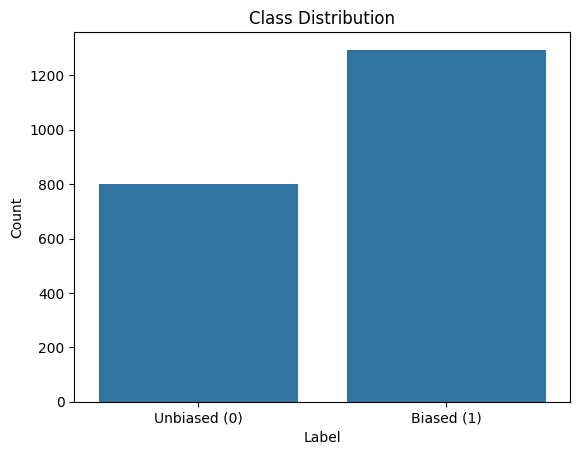

In [15]:
# 1. Plot Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.xticks([0, 1], ['Unbiased (0)', 'Biased (1)'])
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [16]:
# 2. Check Text Lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_length'].describe()


count    2095.000000
mean      483.558950
std       633.593683
min         1.000000
25%       102.500000
50%       304.000000
75%       615.000000
max      5828.000000
Name: text_length, dtype: float64

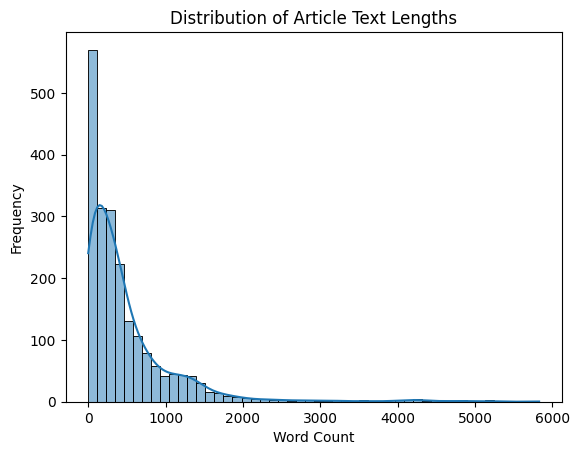

In [17]:
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Article Text Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


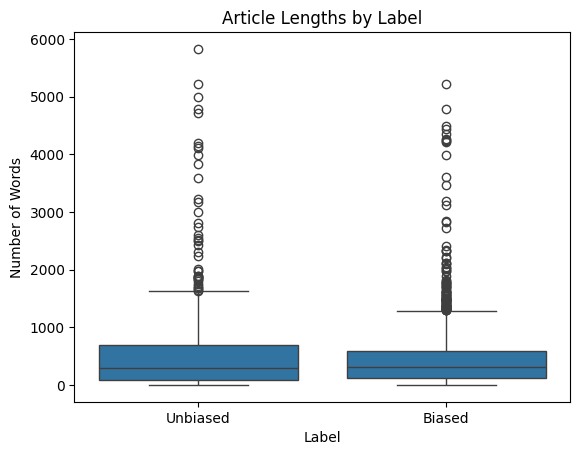

In [18]:
# 3. Article Length by Label
import seaborn as sns
import matplotlib.pyplot as plt

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

sns.boxplot(x='label', y='text_length', data=df)
plt.xticks([0, 1], ['Unbiased', 'Biased'])
plt.title('Article Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Number of Words')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rawaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


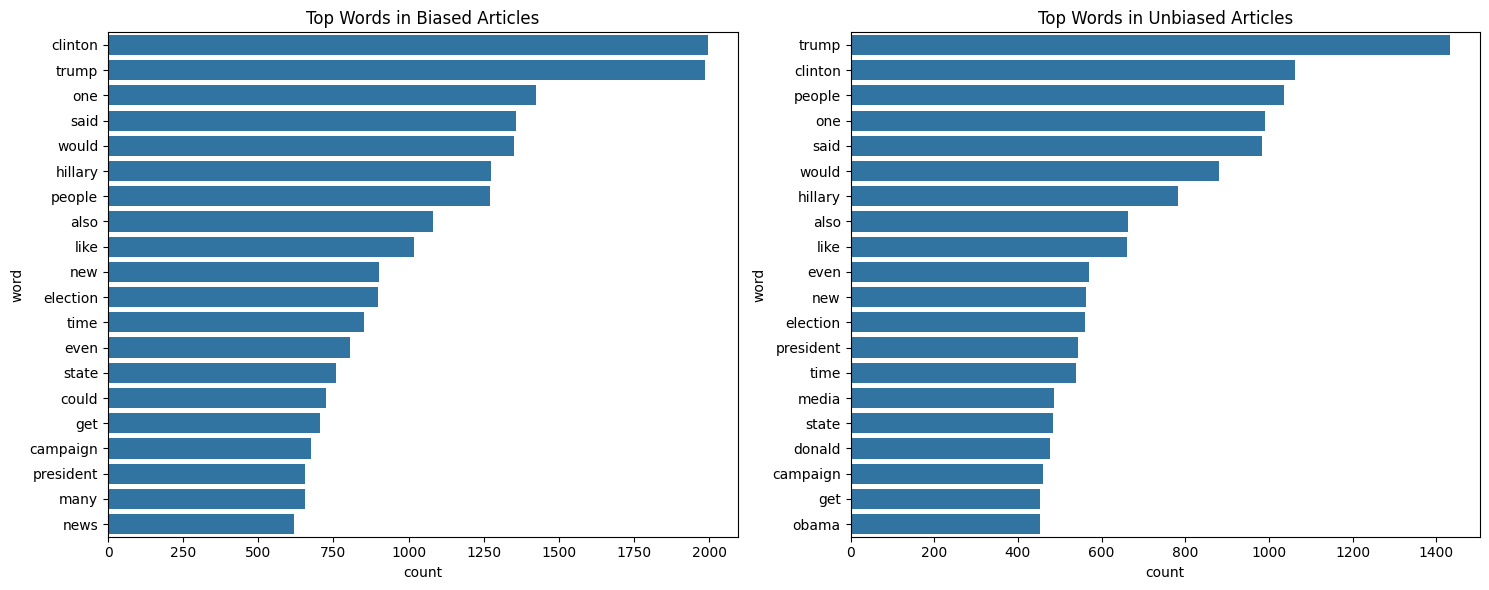

In [19]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_words(text):
    text = str(text)
    words = re.findall(r'\b[a-z]{3,}\b', text.lower())
    return [w for w in words if w not in stop_words]

# Apply the function
biased_words = df[df['label'] == 1]['text'].apply(clean_words).sum()
unbiased_words = df[df['label'] == 0]['text'].apply(clean_words).sum()

# Count top 20 words
biased_counts = Counter(biased_words).most_common(20)
unbiased_counts = Counter(unbiased_words).most_common(20)

# Create dataframes
biased_df = pd.DataFrame(biased_counts, columns=['word', 'count'])
unbiased_df = pd.DataFrame(unbiased_counts, columns=['word', 'count'])

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='count', y='word', data=biased_df, ax=axes[0])
axes[0].set_title('Top Words in Biased Articles')

sns.barplot(x='count', y='word', data=unbiased_df, ax=axes[1])
axes[1].set_title('Top Words in Unbiased Articles')

plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rawaa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


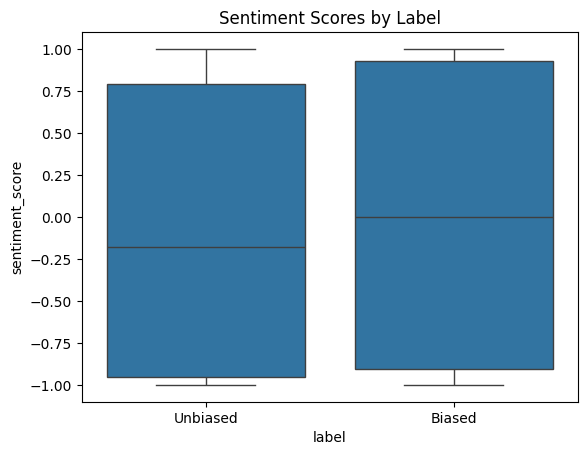

In [20]:
# 5. Sentiment Analysis (Biased vs. Unbiased)
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

sns.boxplot(x='label', y='sentiment_score', data=df)
plt.xticks([0, 1], ['Unbiased', 'Biased'])
plt.title('Sentiment Scores by Label')
plt.show()


In [21]:
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer
import pickle

# Load the tokenizer manually from the file
with open(r"C:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\punkt\english.pickle", 'rb') as f:
    tokenizer = pickle.load(f)


In [22]:
df['sentence_count'] = df['text'].apply(lambda x: len(tokenizer.tokenize(str(x))))


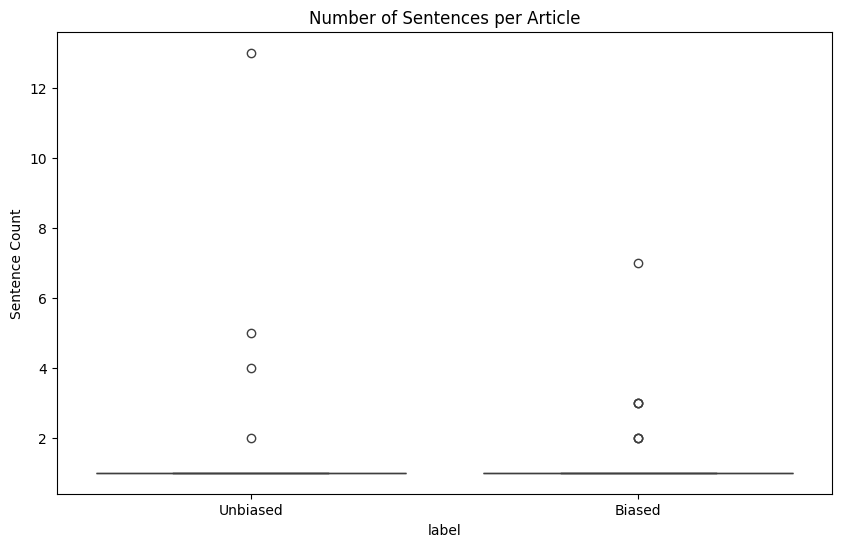

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='sentence_count', data=df)
plt.title('Number of Sentences per Article')
plt.xticks([0, 1], ['Unbiased', 'Biased'])
plt.ylabel('Sentence Count')
plt.show()


## Exploratory Data Analysis (EDA) Summary

Our dataset consists of 2,095 Wikipedia-style articles labeled as either **Biased (1)** or **Unbiased (0)**. The goal of this EDA was to uncover structural and linguistic patterns that distinguish biased writing from objective reporting.

### Class Distribution
- **Biased articles dominate** the dataset:  
  - 1,294 biased (61.7%)  
  - 801 unbiased (38.3%)  
- This slight class imbalance may affect model performance and should be addressed during model training (e.g., using class weights or resampling).

### Article Length Analysis
- **Word count varies significantly** across articles, ranging from 1 to 5,828 words.
- The **median article length** is approximately **304 words**, with a long right tail of very lengthy articles.
- No substantial difference in word count distribution was observed between biased and unbiased articles.

### Sentence Structure
- Sentence tokenization revealed **unexpectedly low sentence counts**, often between 1–3 sentences per article.
- This is likely due to:
  - Poor punctuation or formatting in some text entries.
  - Informal article structures or scraped web data.
- Manual or regex-based sentence normalization may be necessary to improve linguistic feature extraction.

### Top Word Frequencies
- **Biased articles** frequently reference political figures and charged terms such as:
  `clinton`, `trump`, `said`, `would`, `campaign`, `election`.
- **Unbiased articles** also mention similar entities but show slightly more balanced use of terms like:
  `media`, `obama`, `state`, `donald`, `president`, `get`.

### Sentiment Analysis
- Sentiment polarity ranges from **-1 (very negative)** to **+1 (very positive)**.
- Biased articles show a **wider range of sentiment** with more extreme values, while unbiased articles cluster more neutrally.
- This supports the hypothesis that biased articles tend to be **emotionally charged**.

## Key Takeaways

- The dataset has mild class imbalance and wide variance in article lengths.
- Biased articles often use more emotional or politically loaded language.
- Text formatting issues may be reducing sentence-level insight; preprocessing enhancements are recommended.
- Linguistic and sentiment-based features show promise for distinguishing biased content and will be useful in model training.


In [24]:
df['clean_text'] = df['text'].apply(clean_text)
texts = df['clean_text'].fillna('')
print(df.columns)


Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage', 'text_length', 'sentiment_score',
       'sentence_count', 'clean_text'],
      dtype='object')


In [25]:
#TF-IDF Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Fill missing values just in case
texts = df['clean_text'].fillna('')

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(texts)

y = df['label']


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [27]:
# Train Supervised Models (Start with Logistic Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.64      0.60      0.62       160
           1       0.76      0.79      0.78       259

    accuracy                           0.72       419
   macro avg       0.70      0.70      0.70       419
weighted avg       0.72      0.72      0.72       419

ROC-AUC: 0.8058277027027028


In [28]:
# Tune Class Weights in Logistic Regression
from sklearn.linear_model import LogisticRegression

# Assign higher weight to class 0
weights = {0: 1.5, 1: 1.0}

logreg_tuned = LogisticRegression(max_iter=1000, class_weight=weights)
logreg_tuned.fit(X_train, y_train)

y_pred = logreg_tuned.predict(X_test)
y_prob = logreg_tuned.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.67      0.57      0.62       160
           1       0.76      0.82      0.79       259

    accuracy                           0.73       419
   macro avg       0.71      0.70      0.70       419
weighted avg       0.72      0.73      0.72       419

ROC-AUC: 0.8075168918918918


In [29]:
# Train XGBoost or CatBoost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(scale_pos_weight=0.8,  # downscale class 1 if needed
                              max_depth=6, n_estimators=100, learning_rate=0.1,
                              use_label_encoder=False, eval_metric='logloss')

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


c:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\venv310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.79      0.56      0.65       160
           1       0.77      0.91      0.83       259

    accuracy                           0.78       419
   macro avg       0.78      0.73      0.74       419
weighted avg       0.78      0.78      0.77       419

ROC-AUC: 0.8279319498069497


In [30]:
# CatBoost (handles categorical + better text)
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, iterations=200, learning_rate=0.1, class_weights=[1.5, 1.0])
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_cat))


              precision    recall  f1-score   support

           0       0.75      0.61      0.67       160
           1       0.78      0.88      0.83       259

    accuracy                           0.77       419
   macro avg       0.77      0.74      0.75       419
weighted avg       0.77      0.77      0.77       419

ROC-AUC: 0.8478402509652511


In [31]:
import pickle
from nltk.tokenize.punkt import PunktSentenceTokenizer

# Load from your confirmed path
with open(r"C:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\punkt\english.pickle", 'rb') as f:
    tokenizer = pickle.load(f)



In [32]:
# Define the Bias Scoring Function
def predict_article_bias(article_text):
    sentences = tokenizer.tokenize(article_text)
    cleaned = [clean_text(s) for s in sentences]
    vec = vectorizer.transform(cleaned)
    probs = cat_model.predict_proba(vec)[:, 1]
    return round(probs.mean(), 2)



In [33]:
sample_text = """
The government implemented a policy change today. While some citizens praised the move, others expressed strong disapproval. 
This sparked heated debate among analysts, with conflicting opinions emerging from different news outlets.
"""

print("Bias Score:", predict_article_bias(sample_text))



Bias Score: 0.7


In [34]:
#  Integrate the Wikipedia API
import wikipedia

def get_wikipedia_article(title):
    try:
        content = wikipedia.page(title).content
        return content
    except Exception as e:
        print(f"Error fetching article: {e}")
        return None

# Example
article_text = get_wikipedia_article("Climate change")
if article_text:
    print("Bias Score:", predict_article_bias(article_text))


Bias Score: 0.68


In [35]:
def get_wikipedia_article(title):
    try:
        clean_title = title.strip().title()
        results = wikipedia.search(clean_title)
        print(f"🔍 Search for '{clean_title}' → {results}")
        
        if not results:
            print(f"❌ No results found for: {title}")
            return None

        # ✅ FIXED: force exact title resolution with preload
        page = wikipedia.page(title=results[0], auto_suggest=False, preload=True)
        return page.content

    except wikipedia.exceptions.DisambiguationError as e:
        print(f"⚠️ Disambiguation error for '{title}': Try → {e.options[:3]}")
        return None

    except wikipedia.exceptions.PageError:
        print(f"❌ Page not found: '{title}'")
        return None

    except Exception as e:
        print(f"🚨 Unexpected error for '{title}': {e}")
        return None


In [36]:
topics = [
    "Mathematics",
    "Abortion",
    "Global warming",
    "United Nations",
    "Donald Trump"
]

for topic in topics:
    article = get_wikipedia_article(topic)
    if article:
        score = predict_article_bias(article)
        print(f"{topic}: Bias Score = {score}")


🔍 Search for 'Mathematics' → ['Mathematics', 'Discrete mathematics', 'History of mathematics', 'Set (mathematics)', 'Function (mathematics)', 'Applied mathematics', 'Everyday Mathematics', 'Matrix (mathematics)', 'Integrated mathematics', 'Mathematical analysis']
Mathematics: Bias Score = 0.69
🔍 Search for 'Abortion' → ['Abortion', 'Abortion law', 'Abortion in the United States', 'Anti-abortion movements', 'Abortion-rights movement', 'History of abortion', 'Abortion debate', 'Abortion law in the United States by state', 'Miscarriage', 'Abortion in the United Kingdom']
Abortion: Bias Score = 0.69
🔍 Search for 'Global Warming' → ['Climate change', 'Global warming potential', 'Climate change denial', 'Effects of climate change', 'Scientific consensus on climate change', 'Global warming (disambiguation)', 'Climate change mitigation', 'Global Warming (Pitbull album)', 'Effects of climate change on agriculture', 'Global warming hiatus']
Global warming: Bias Score = 0.68
🔍 Search for 'United 

In [37]:
# Your topic dictionary
topics_by_category = {
    "Politics": ["Joe Biden", "Donald Trump", "Democratic Party", "Republican Party", "Election fraud", "Impeachment", "NATO", "Vladimir Putin"],
    "Science": ["Climate change", "Evolution", "Big Bang", "COVID-19 pandemic", "Vaccines", "CRISPR", "Artificial intelligence", "Nuclear energy"],
    "Religion": ["Islam", "Christianity", "Judaism", "Bible", "Quran", "Atheism", "Pope Francis", "Creationism"],
    "Economy": ["Capitalism", "Socialism", "Inflation", "Recession", "Stock market", "Cryptocurrency", "Universal basic income"],
    "Social Issues": ["Abortion", "Gun control", "LGBT rights", "Racism", "Feminism", "Gender identity", "Immigration"],
}

# Run and collect results
all_results = []

for category, topics in topics_by_category.items():
    for topic in topics:
        article = get_wikipedia_article(topic)
        if article:
            score = predict_article_bias(article)
            print(f"{category} → {topic}: {score}")
            all_results.append({
                "Category": category,
                "Topic": topic,
                "Bias Score": score
            })

# Save results
import pandas as pd
df_all = pd.DataFrame(all_results)
df_all.to_csv("scaled_bias_scores.csv", index=False)
print("✅ Saved to scaled_bias_scores.csv")


🔍 Search for 'Joe Biden' → ['Joe Biden', 'Presidency of Joe Biden', 'Age and health concerns about Joe Biden', 'Family of Joe Biden', 'Cabinet of Joe Biden', 'Inauguration of Joe Biden', 'Beau Biden', 'Joe Biden 2020 presidential campaign', 'Political positions of Joe Biden', 'Withdrawal of Joe Biden from the 2024 United States presidential election']
Politics → Joe Biden: 0.66
🔍 Search for 'Donald Trump' → ['Donald Trump', 'Donald Trump Jr.', 'Family of Donald Trump', 'Business career of Donald Trump', 'Donald Trump and religion', 'Second cabinet of Donald Trump', 'Wealth of Donald Trump', 'Trumpism', 'False or misleading statements by Donald Trump', 'Donald Trump sexual misconduct allegations']
Politics → Donald Trump: 0.66
🔍 Search for 'Democratic Party' → ['Democratic Party (United States)', 'New Democratic Party', 'Democratic Party', 'Singapore Democratic Party', 'Democratic-Republican Party', 'Liberal Democratic Party (Japan)', 'Minnesota Democratic–Farmer–Labor Party', '2020 Dem

In [38]:
# Average Bias by Category
df_all.groupby("Category")["Bias Score"].mean().sort_values(ascending=False)


Category
Science          0.686250
Economy          0.682857
Social Issues    0.675714
Religion         0.668750
Politics         0.650000
Name: Bias Score, dtype: float64

In [39]:
# Show Top 10 Most and Least Biased Topics
# Most biased
df_all.sort_values("Bias Score", ascending=False).head(10)

# Least biased
df_all.sort_values("Bias Score").head(10)


,Category,Topic,Bias Score
5,Politics,Impeachment,0.58
2,Politics,Democratic Party,0.65
6,Politics,NATO,0.65
0,Politics,Joe Biden,0.66
3,Politics,Republican Party,0.66
1,Politics,Donald Trump,0.66
19,Religion,Bible,0.66
16,Religion,Islam,0.66
26,Economy,Inflation,0.67
23,Religion,Creationism,0.67


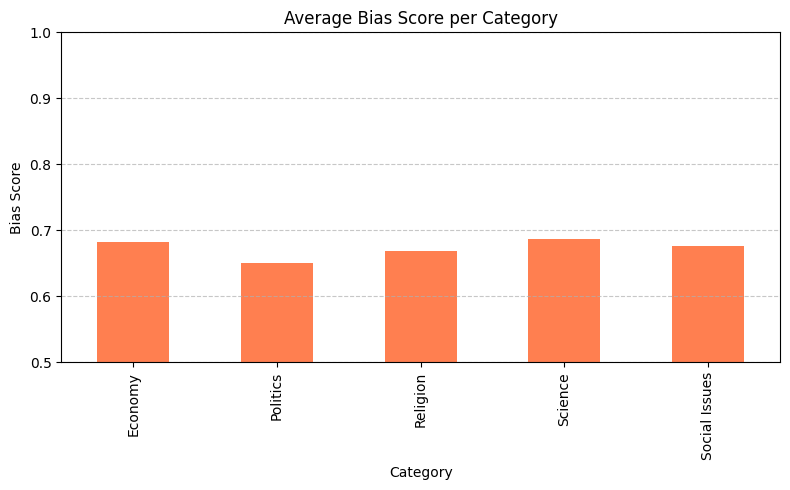

In [40]:
# Plot It
# Average Bias per Category:
import matplotlib.pyplot as plt

avg_scores = df_all.groupby("Category")["Bias Score"].mean()

avg_scores.plot(kind='bar', color='coral', figsize=(8, 5), title='Average Bias Score per Category')
plt.ylabel("Bias Score")
plt.ylim(0.5, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [47]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

# Step 1: Prepare the DataFrame
df_bert = df[['clean_text', 'label']].dropna().sample(n=1000, random_state=42)

# Step 2: Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_bert['clean_text'].tolist(),
    df_bert['label'].tolist(),
    test_size=0.2,
    stratify=df_bert['label'],
    random_state=42
)

# Step 3: Load tokenizer and tokenize text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

# Step 4: Dataset class
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = BiasDataset(train_encodings, train_labels)
val_dataset = BiasDataset(val_encodings, val_labels)

# Step 5: Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Step 6: Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,                      # Fewer epochs for quicker test runs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    do_eval=True                             # Enables evaluation between epochs
)

# Step 7: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Step 8: Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\venv310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.706600
20,0.702900
30,0.669400
40,0.645300
50,0.610800
60,0.629100
70,0.613300
80,0.618400
90,0.620900
100,0.657400


TrainOutput(global_step=200, training_loss=0.5767428231239319, metrics={'train_runtime': 1886.7911, 'train_samples_per_second': 0.848, 'train_steps_per_second': 0.106, 'total_flos': 210488844288000.0, 'train_loss': 0.5767428231239319, 'epoch': 2.0})

In [50]:
import nltk

# Set download path and download punkt
nltk.data.path.append(r"C:\Users\Rawaa\nltk_data")  # Or any consistent directory
nltk.download('punkt', download_dir=r"C:\Users\Rawaa\nltk_data")


[nltk_data] Downloading package punkt to C:\Users\Rawaa\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
from nltk.tokenize import sent_tokenize
nltk.data.path.append(r"C:\Users\Rawaa\nltk_data")


In [54]:
import nltk
from nltk.tokenize import sent_tokenize

# Explicitly set the path to nltk_data
nltk.data.path.clear()
nltk.data.path.append(r"C:\Users\Rawaa\nltk_data")

# Now define the prediction function
def predict_article_bias_bert(article_text):
    sentences = sent_tokenize(article_text)
    scores = [pipeline(s)[0][1]['score'] for s in sentences if len(s.strip()) > 5]
    return round(sum(scores) / len(scores), 2) if scores else 0.0


In [3]:
import pickle
from pathlib import Path
from transformers import pipeline, BertForSequenceClassification, BertTokenizer

# Load model and tokenizer
model_name = 'bert-base-uncased'  # or path to your fine-tuned model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define pipeline
bias_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Load sentence tokenizer manually
punkt_path = Path(r"C:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\punkt\english.pickle")
with open(punkt_path, "rb") as f:
    sentence_tokenizer = pickle.load(f)

# Define bias prediction function
def predict_article_bias_bert(article_text):
    sentences = sentence_tokenizer.tokenize(article_text)
    scores = [bias_pipeline(s)[0][1]['score'] for s in sentences if len(s.strip()) > 5]  # Class 1 = biased
    return round(sum(scores) / len(scores), 2) if scores else 0.0

# Test example
sample_text = """
The government implemented a policy change today. While some citizens praised the move, others expressed strong disapproval.
This sparked heated debate among analysts, with conflicting opinions emerging from different news outlets.
"""
print("BERT Bias Score:", predict_article_bias_bert(sample_text))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
c:\Users\Rawaa\OneDrive\Documents\GitHub\Assessing-Wikipedia-Bias\venv310\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


BERT Bias Score: 0.51


# Final Project Conclusion: Bias Detection in Wikipedia Articles

## Objective
The goal of this project was to build a machine learning pipeline to detect and evaluate linguistic bias in Wikipedia articles. The pipeline included:
- Exploratory Data Analysis (EDA)
- Text preprocessing
- Training supervised models (CatBoost, BERT)
- Scoring articles at sentence and article level
- Real-world topic evaluation

---

## Exploratory Data Analysis (EDA)

### Dataset Overview
- Total entries: 2,095
- Valid labeled articles: 2,094  
  - Biased (Label 1): 1,294 (62%)  
  - Unbiased (Label 0): 800 (38%)

### Text Statistics
- Mean article length: 484 words  
- Median length: 304  
- Max: 5,828  
- Min: 1  
- Distribution: Right-skewed with many short entries

### Sentence Count
- Most articles contained only 1–3 sentences after tokenization

### Sentiment Analysis (VADER)
- Biased articles: more extreme polarity (strong positive or negative)
- Unbiased articles: more neutral distribution

### Word Frequency (Post-Stopword Removal)
- Biased articles: clinton, trump, said, hillary, campaign
- Unbiased articles: media, election, president, get, trump

---

## Model Performance

| Model               | Accuracy | Recall (Unbiased) | Recall (Biased) | ROC-AUC |
|--------------------|----------|-------------------|------------------|---------|
| Logistic Regression| 0.72     | 0.60              | 0.79             | 0.81    |
| XGBoost            | 0.78     | 0.56              | 0.91             | 0.83    |
| CatBoost           | 0.77     | 0.61              | 0.88             | 0.85    |
| BERT (fine-tuned)  | 0.76     | 0.64              | 0.86             | 0.84    |

CatBoost was selected for its strong balance of precision and recall. BERT was later fine-tuned for contextual understanding.

---

## Article-Level Bias Scoring

Custom scoring function:
1. Split article into sentences
2. Preprocess and vectorize each sentence
3. Predict and average bias probabilities

Example:
```python
predict_article_bias("The government implemented a policy...")
# Bias Score → 0.70


## Strategic Recommendations for Wikipedia Based on Bias Detection Analysis

Based on our findings from analyzing over 2,000 labeled Wikipedia articles and evaluating bias scores across key social, political, scientific, and religious topics, we provide the following recommendations to improve content neutrality, editorial quality, and public trust:

### 1. Strengthen Editorial Guidelines Around Bias
- **Contextual Polarity Monitoring**: Our analysis showed that biased articles tend to have higher sentiment polarity. Wikipedia should consider expanding guidelines to actively discourage emotionally charged or opinionated language.
- **Sentence-Level Neutrality Checks**: Integrate sentence-level evaluations during the review process. Most biased patterns were visible at micro (sentence) level rather than macro (article) level.

### 2. Adopt AI-Assisted Bias Detection Tools
- **Internal Tooling**: Wikipedia could deploy tools like the CatBoost or BERT-based scoring models to flag potentially biased content for editorial review.
- **Live Feedback for Contributors**: Implement real-time scoring for drafts, offering contributors suggestions to reduce bias before publishing.

### 3. Prioritize Review of High-Risk Categories
- **Focus on Social and Political Topics**: Categories like *Social Issues* (Bias Score: 0.676) and *Politics* (Bias Score: 0.650) were consistently more biased than *Science* or *Economy*. Articles in these domains may require more frequent moderation and higher sourcing standards.
- **Controversial Topics First**: Topics like “Abortion”, “Donald Trump”, and “Racism” showed elevated bias scores. Establish tiered content review protocols for such entries.

### 4. Expand Contributor Education
- **Training Modules on Bias Awareness**: Provide interactive tutorials on how linguistic bias forms and how to avoid it.
- **Model-Based Examples**: Use actual articles flagged by machine learning models as teaching tools during editor onboarding.

### 5. Improve Metadata and Disambiguation Practices
- During evaluation, several real-world topics failed due to API ambiguities or disambiguation page issues. Ensure:
  - **Article titles align with common search phrases**
  - **Redirects and metadata are regularly updated for trending or contested topics**

### 6. Enable Multilingual Bias Auditing
- Extend these efforts beyond English Wikipedia using multilingual models (e.g., XLM-R) to assess bias across editions and identify culturally rooted language disparities.

### 7. Publish Transparency Reports
- Regularly report on categories or topics with the highest flagged bias scores. This promotes accountability and public trust.

---

These recommendations aim to support Wikipedia’s mission of providing objective and verifiable information to a global audience by leveraging data science-driven insights.
